In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
import pathlib
import scipy
import subprocess
import gc

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import cv2


from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import SGD
from keras.optimizers import Adam

from sklearn.utils import shuffle
from sklearn.metrics import fbeta_score


#from six import string_types
#from IPython.display import display
#from sklearn.model_selection import train_test_split
#from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
#from keras.preprocessing import image as image_utils
#from keras import applications

In [3]:
!ls /kaggle/input/

planets-dataset


In [6]:
!ls /kaggle/input/planets-dataset/

planet	test-jpg-additional


In [7]:
# Loading the tags
train_df = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
train_df.columns = ["image_name", "tags"]
train_df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [8]:
test_df = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
test_df

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water
...,...,...
61186,file_9995,primary clear agriculture road water
61187,file_9996,primary clear agriculture road water
61188,file_9997,primary clear agriculture road water
61189,file_9998,primary clear agriculture road water


In [9]:
# Building a list with unique labels
label_list = []
for tag_str in train_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

            
# Display label list and length 
print(f'The number of data samples is {len(train_df)}. And there are {len(label_list)} unique possible classes.', '\n' 
      f'The Label list includes {label_list}')

The number of data samples is 40479. And there are 17 unique possible classes. 
The Label list includes ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [10]:
# Split the tags column to get the unique labels (as key: values dictionary combination)
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in train_df['tags'].values])))


# Creating a label map
label_map = {l: i for i, l in enumerate(labels)}

print(f'label_map = {label_map},\n length = {len(label_map)}')

label_map = {'slash_burn': 0, 'blooming': 1, 'selective_logging': 2, 'artisinal_mine': 3, 'agriculture': 4, 'haze': 5, 'road': 6, 'cultivation': 7, 'partly_cloudy': 8, 'habitation': 9, 'blow_down': 10, 'conventional_mine': 11, 'clear': 12, 'water': 13, 'bare_ground': 14, 'primary': 15, 'cloudy': 16},
 length = 17


In [11]:
# Applying one-hot encoding to the unique labels ---[0 0 0 1 0 0 0 0 0 0]
train_tag_data = train_df.copy()
for label in label_list:
    train_tag_data[label] = train_tag_data['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)

# Display head
train_tag_data.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [12]:

# Printing decreasing frequenciy of instances for each category
category_counts = {}

for column in train_tag_data.columns[2:]:
     category_counts[column] = train_tag_data[column].value_counts()[1]

for w in sorted(category_counts, key=category_counts.get, reverse=True):
    print(category_counts[w] , w )

37513 primary
28431 clear
12315 agriculture
8071 road
7411 water
7261 partly_cloudy
4477 cultivation
3660 habitation
2697 haze
2089 cloudy
862 bare_ground
340 selective_logging
339 artisinal_mine
332 blooming
209 slash_burn
100 conventional_mine
98 blow_down


In [13]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([labels.split(" ") for labels in train_tag_data['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))


There is 17 unique labels including {'slash_burn', 'blooming', 'selective_logging', 'artisinal_mine', 'agriculture', 'haze', 'road', 'cultivation', 'partly_cloudy', 'habitation', 'blow_down', 'conventional_mine', 'clear', 'water', 'bare_ground', 'primary', 'cloudy'}


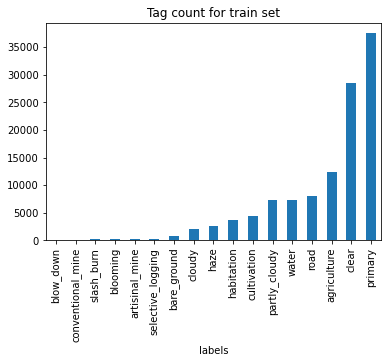

In [14]:
#Alternatively, making a simple plot of the label list
# Histogram of label instances
train_tag_data[label_list].sum().sort_values().plot.bar();
plt.xlabel('labels')
plt.title('Tag count for train set');

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
haze,2697,2670,672,0,613,129,394,202,3,0,0,2,41,5,4,5,0
primary,2670,37513,11972,27668,7001,3469,7728,4455,209,0,7175,94,683,324,332,340,98
agriculture,672,11972,12315,9150,2712,2737,6034,3377,119,0,2493,24,225,38,32,65,22
clear,0,27668,9150,28431,5502,3090,6295,3527,173,0,0,70,747,307,311,308,85
water,613,7001,2712,5502,7411,915,2125,868,24,0,1295,26,206,299,16,49,3
habitation,129,3469,2737,3090,915,3660,2786,895,41,0,441,36,163,29,4,13,3
road,394,7728,6034,6295,2125,2786,8071,1294,36,0,1382,59,323,110,10,151,2
cultivation,202,4455,3377,3527,868,895,1294,4477,126,0,748,4,89,18,35,58,8
slash_burn,3,209,119,173,24,41,36,126,209,0,33,0,10,0,2,2,2
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


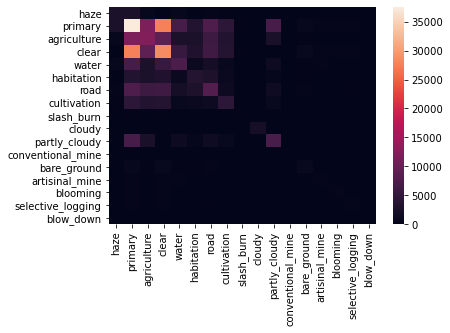

In [43]:
# function for cooocurence matrix plotting
def make_cooccurence_matrix(labels):
    numeric_data = train_tag_data[labels]; 
    c_matrix = numeric_data.T.dot(numeric_data)
    sns.heatmap(c_matrix)
    return c_matrix
    
# Compute the co-ocurrence matrix
make_cooccurence_matrix(label_list)

Each image should have exactly one weather label:

,clear,partly_cloudy,haze,cloudy
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
haze,0,0,2697,0
cloudy,0,0,0,2089


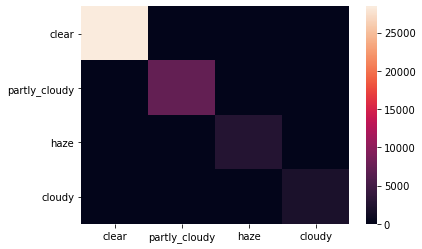

In [16]:
# plot weather element cooccurence matrix
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_cooccurence_matrix(weather_labels)


But the land labels may overlap:

,primary,agriculture,water,cultivation,habitation
primary,37513,11972,7001,4455,3469
agriculture,11972,12315,2712,3377,2737
water,7001,2712,7411,868,915
cultivation,4455,3377,868,4477,895
habitation,3469,2737,915,895,3660


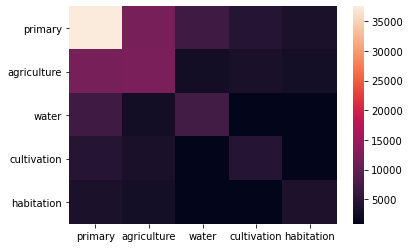

In [17]:
# plot land-use element classes cooccurence matrix
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
make_cooccurence_matrix(land_labels)

**PREVIEW IMAGES IN EACH CATEGORY**

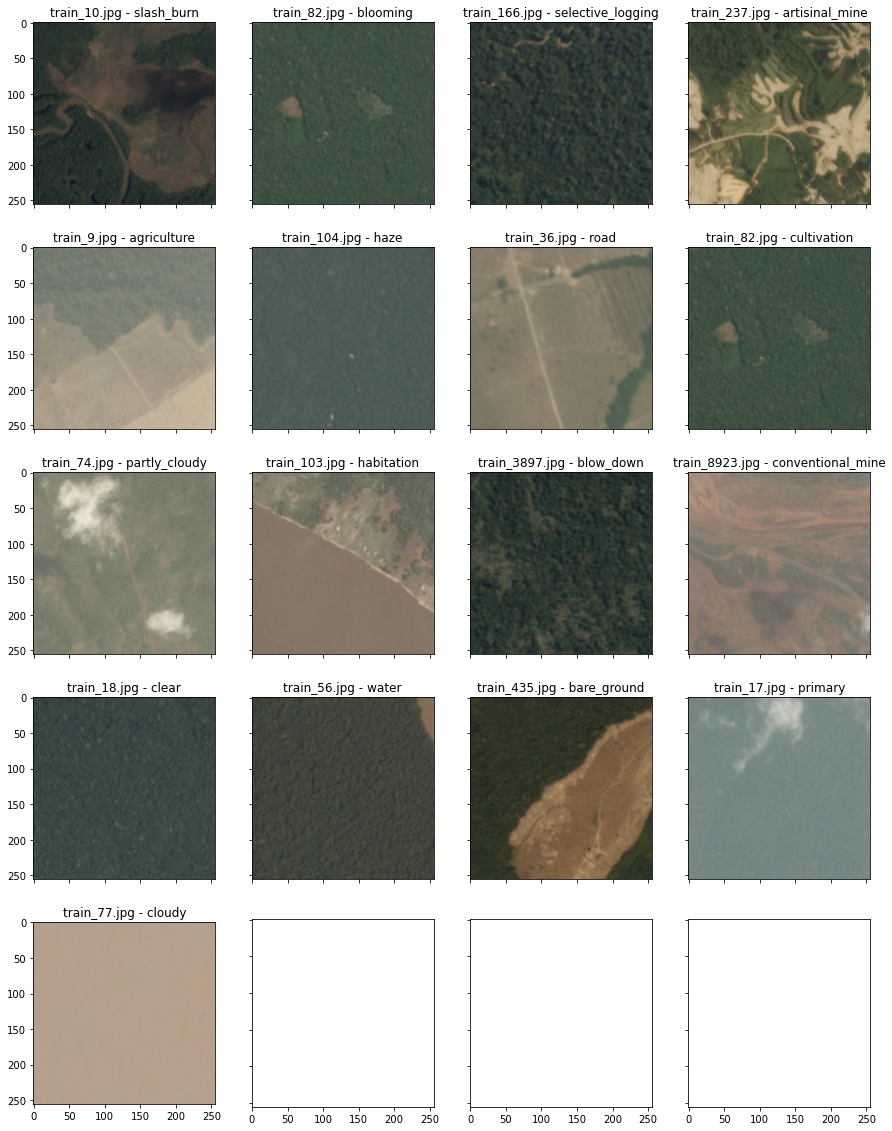

In [18]:
images = [train_df[train_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

# /kaggle/input/planets-dataset/planet/planet/train_classes.csv
# /kaggle/input/planets-dataset/planet/planet/train-jpg

for i, (image_name, label) in enumerate(zip(images, labels_set)):
    img = mpimg.imread('../input/planets-dataset/planet/planet/train-jpg' + '/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))



## **PRE-PROCESSING Data for the Model,** and Image Preprocessing


In [44]:
# define input size. Data Length Check (or checking smapple size)
input_size = 64

In [45]:
# Split the tags column to get the unique labels
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in train_df['tags'].values])))


# Create label map
label_map = {l: i for i, l in enumerate(labels)}

print(f'label_map = {label_map},\n length = {len(label_map)}')

label_map = {'slash_burn': 0, 'blooming': 1, 'selective_logging': 2, 'artisinal_mine': 3, 'agriculture': 4, 'haze': 5, 'road': 6, 'cultivation': 7, 'partly_cloudy': 8, 'habitation': 9, 'blow_down': 10, 'conventional_mine': 11, 'clear': 12, 'water': 13, 'bare_ground': 14, 'primary': 15, 'cloudy': 16},
 length = 17


In [46]:
x_train = []
y_train = []

for f, tags in tqdm(train_df.values, miniters=1000):
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    img = cv2.resize(img, (input_size, input_size))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train.append(img)
    y_train.append(targets)
        
x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.uint8)

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [02:33<00:00, 262.88it/s]


(40479, 64, 64, 3)
(40479, 17)


In [47]:
# creating x_test
x_test = []

test_jpg_dir = '../input/planets-dataset/planet/planet/test-jpg'
test_image_names = os.listdir(test_jpg_dir)

n_test = len(test_image_names)
test_classes = test_df.iloc[:n_test, :]
add_classes = test_df.iloc[n_test:, :]


test_jpg_add_dir = '../input/planets-dataset/test-jpg-additional/test-jpg-additional'
test_add_image_names = os.listdir(test_jpg_add_dir)

for img_name, _ in tqdm(test_classes.values, miniters=1000):
    img = cv2.imread(test_jpg_dir + '/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (64, 64)))
    
for img_name, _ in tqdm(add_classes.values, miniters=1000):
    img = cv2.imread(test_jpg_add_dir + '/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (64, 64)))

x_test = np.array(x_test, np.float32)
print(x_test.shape)

100%|██████████| 20522/20522 [00:55<00:00, 370.21it/s]


(61191, 64, 64, 3)


In [48]:
# split the train data into train and validation data sets
X_train = x_train[ :33000]
Y_train = y_train[ :33000]

X_valid = x_train[33000: ]
Y_valid = y_train[33000: ]

In [50]:
# specify sizes (batch and model input) and number of input channels
input_size = 64
input_channels = 3
batch_size = 64

In [51]:
train_steps = np.ceil(len(X_train) / batch_size)
val_steps = np.ceil(len(X_valid) / batch_size )

## **Model Training**

### Defining the model Archtecture

In [52]:
from tensorflow.keras.models import Model

In [34]:
# Add model parameters including dropout, layers and activation function
base_model = VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=(input_size, input_size, input_channels))

for layer in base_model.layers:
            layer.trainable = False   ## We should freeze trainable layers

model = base_model.output
model = BatchNormalization(input_shape=(input_size, input_size, input_channels))(model)

model = MaxPooling2D(pool_size=(2, 2))(model)
model = Dropout(0.25)(model)

model = Flatten()(model)
model = Dense(2048, activation='relu')(model) # you can choose to increase or decrease the Dense layers, just experimental
model = Dropout(0.5)(model)
model = Dense(17, activation='sigmoid')(model)
model = Model(base_model.input,model)

In [35]:
# define model training optimizer parameters
optimizer  = SGD(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['AUC'])
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
                ModelCheckpoint(filepath='weights/best_weights',
                                 save_best_only=True,
                                 save_weights_only=True)]
model.summary()

In [36]:
history = model.fit(X_train,Y_train, epochs=30, callbacks=[callbacks],steps_per_epoch=train_steps, batch_size = batch_size,
                            verbose=1, shuffle=False,validation_data=(X_valid,Y_valid), validation_steps=val_steps)

In [37]:
p_val = model.predict(X_valid, batch_size = batch_size, verbose=2)
print(fbeta_score(Y_valid, np.array(p_val) > 0.35, beta=2, average='samples')) #Check the model performance on the validation set

In [38]:
p_test = model.predict(x_test, batch_size = batch_size, verbose=2) #save the test predictions

result = np.array(p_test)
result = pd.DataFrame(result, columns = labels)
result.head(2)

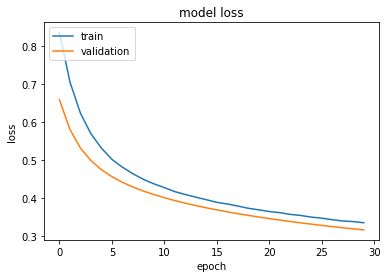

In [32]:
# summarize and plot train loss and valid loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [33]:
# So now have your predictions, just change it to the sample submission format and you're good to submit
test_df.to_csv('amazon_sample_submission10.csv', index=False)
